the basic idea for my strategy is to adjust my portfolio monthly or quarterly based on feature_3 and after that we can change the portofolio on a daily base based on feature_9 to improve the performance of inventory, the training period is 2010-2015 and the test period is 2017,2018

In [272]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



In [273]:
feature_3 = pd.read_csv("feature_3.csv")
feature_9 = pd.read_csv("feature_9.csv")
stock_rtn = pd.read_csv("stock_rtn.csv")

In [274]:
def add_quarter_month(dataframe):
    def tranfer(string):
        if string in ["01","02","03"]:
            return 1
        if string in ["04","05","06"]:
            return 2
        if string in ["07","08","09"]:
            return 3
        if string in ["10","11","12"]:
            return 4
    dataframe["year"] = dataframe["data_date"].apply(lambda x: int(str(x)[:4]))
    dataframe["month"] = dataframe["data_date"].apply(lambda x:str(x)[:6])
    dataframe["quarter"] = dataframe["data_date"].apply(lambda x: tranfer(str(x)[4:6]))
    dataframe["year"] = dataframe["year"].apply(lambda x: str(x))
    dataframe["quarter"] = dataframe["quarter"].apply(lambda x: "q"+str(x))
    dataframe["quarter"]  = dataframe["year"] + dataframe["quarter"] 
    return dataframe

def Rank_qcut(vector, K):
    quantile = np.array([float(i) / K for i in range(K + 1)]) # Quantile: K+1 values
    funBounder = lambda x: (quantile >= x).argmax()
    return vector.rank(pct=True).apply(funBounder)



def cal_rtn(series):
    num = len(series)
    list_temp = []
    ret_temp = 1
    for i in range(num):
        ret_temp *= (1+series[i])
        list_temp.append(ret_temp)
    return list_temp

calaulate the monthly and quarterly return of a stock and add it to feature_3

In [275]:
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn_mon = stock_rtn.groupby(["security_id","month"])["log_ret_1"].sum()
stock_rtn_mon = pd.DataFrame(stock_rtn_mon)
stock_rtn_mon["month_ret"]= stock_rtn_mon["log_ret_1"].apply(lambda x: math.exp(x)-1)
stock_rtn_mon.to_csv("stock_rtn_month.csv")
stock_rtn_quarter = stock_rtn.groupby(["security_id","quarter"])["log_ret_1"].sum()
stock_rtn_quarter = pd.DataFrame(stock_rtn_quarter)
stock_rtn_quarter["quarter_ret"]= stock_rtn_quarter["log_ret_1"].apply(lambda x: math.exp(x)-1)
stock_rtn_quarter.to_csv("stock_rtn_quarter.csv")

In [276]:
feature_3  = add_quarter_month(feature_3)

In [277]:
feature_3

,Unnamed: 0,data_date,security_id,d3,year,quarter,log_ret_66,month
0,0,20100817,5916301,-356.424242,2010,2010q3,NaN,201008
1,1,20111116,1895201,-329.276316,2011,2011q4,-0.019947,201111
2,2,20130510,7928501,-243.046958,2013,2013q2,0.747614,201305
3,3,20150817,5461901,-172.178042,2015,2015q3,0.019048,201508
4,4,20110307,4950001,-141.513859,2011,2011q1,NaN,201103
...,...,...,...,...,...,...,...,...
99928,99928,20161104,1113998301,167.116645,2016,2016q4,NaN,201611
99929,99929,20160506,1111093301,175.872093,2016,2016q2,0.178801,201605
99930,99930,20170814,1400901,287.705645,2017,2017q3,1.055928,201708
99931,99931,20170810,1115045501,425.328185,2017,2017q3,0.477501,201708


In [278]:
quarter_list = sorted(list(set(feature_3["quarter"])))
def next_quarter(x):
    ind = quarter_list.index(x)
    try:
        return quarter_list[ind+1]
    except:
        return np.nan
month_list = sorted(list(set(feature_3["month"])))

def next_month(x):
    ind = month_list.index(x)
    try:
        return month_list[ind+1]
    except:
        return np.nan
    
feature_3["next_quarter"] = feature_3["quarter"].apply(next_quarter)
feature_3["next_month"] = feature_3["month"].apply(next_month)
feature_3 = feature_3[["data_date","security_id","d3","quarter","month","next_quarter","next_month"]].fillna(0)

add next_month return and next_quarter return 

In [279]:
stock_rtn_quarter = pd.read_csv("stock_rtn_quarter.csv")
stock_rtn_month = pd.read_csv("stock_rtn_month.csv")
stock_rtn_month["next_month"] = stock_rtn_month["month"]
stock_rtn_quarter["next_quarter"] = stock_rtn_quarter["quarter"]


In [280]:
feature_3 = pd.merge(feature_3,stock_rtn_quarter,on = ["security_id","next_quarter"],how = "left")
feature_3 =  pd.merge(feature_3,stock_rtn_month,on = ["security_id","next_month"],how = "left")

In [281]:
feature_3 = feature_3[["data_date","security_id","d3","next_quarter","next_month","month_ret","quarter_ret"]]
feature_3 = feature_3.dropna()
feature_3.index = range(len(feature_3))

# construction of the strategy

to start with we will explore the strategy without considering whether a stock is in the universe, here feature_3_monthly_quarterly.csv contains feature_3 of last month and last quarter

In [312]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

change the portfolio quarterly

In [313]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")


In [314]:
stock_rtn = stock_rtn.dropna()

In [315]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        #q1 = q1[q1.in_trading_universe == "Y"]
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

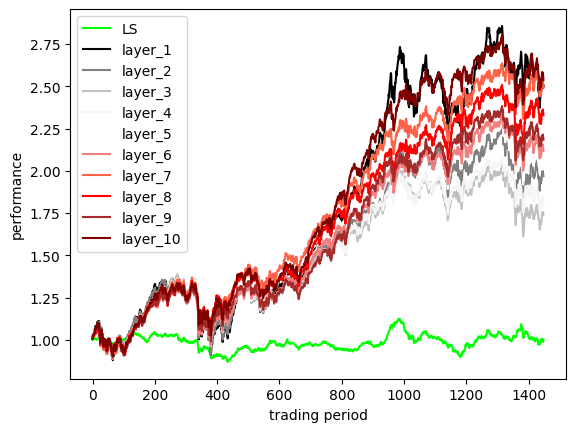

In [316]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [317]:
k = pd.Series(k10)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.2322521709156713
annual return 0.17453851080527838
Sharpe ratio 1.004067534975918


In [318]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.33836402483453254
annual return 0.17179877451275294
Sharpe ratio 0.8409170285821507


layer_10 has the best performance and the long-short strategy does not have a good performance

In [289]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

In [290]:
stock_rtn_with_feature_3_layer = layer_by_day(stock_rtn)
stock_rtn_with_feature_3_layer.to_csv("stock_rtn_with_feature_3_quarter.csv")

In [291]:
stock_rtn_with_feature_3_layer

,Unnamed: 0.1,Unnamed: 0,data_date,security_id,close_price,volume,group_id,in_trading_universe,ret1d,log_ret_1,year,month,quarter,matching_quarter,d3,layer
283581,283581,283581,20100401,77901,22.690,101968.0,20102010,N,0.003095,0.016609,2010,201004,2010q2,2010q2,114.744948,8
283582,283582,283582,20100401,78001,24.880,181509.0,20101010,Y,0.002417,0.019109,2010,201004,2010q2,2010q2,129.845322,9
283583,283583,283583,20100401,78401,22.140,2223226.0,20104020,Y,0.013736,-0.003620,2010,201004,2010q2,2010q2,81.574331,7
283585,283585,283585,20100401,83501,7.730,381209.0,20201060,N,0.009138,0.026804,2010,201004,2010q2,2010q2,56.693439,6
283590,283590,283590,20100401,85801,3.920,13044.0,35103010,N,-0.020000,-0.002554,2010,201004,2010q2,2010q2,44.311207,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8873441,8799867,4488192,20171229,1117154001,48.680,1059516.0,25504030,Y,-0.018350,0.000000,2017,201712,2017q4,2017q4,5.831430,4
8873447,8799873,4488198,20171229,1117183001,11.871,2340.0,35202010,N,-0.003701,0.000000,2017,201712,2017q4,2017q4,-473.180782,1
8873462,8799888,4488213,20171229,1117266801,63.140,134357.0,35201010,Y,0.009594,0.000000,2017,201712,2017q4,2017q4,-88.534543,2
8873464,8799890,4488215,20171229,1117267401,28.840,685655.0,45101010,Y,0.000695,0.000000,2017,201712,2017q4,2017q4,78.686026,9


change the portfolio monthly

In [304]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_month"]]
feature_3["matching_month"] = feature_3["next_month"]
feature_3["matching_month"] = feature_3["matching_month"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_month",axis =1)

In [305]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_month"] = stock_rtn["month"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_month"],how = "left")
stock_rtn = stock_rtn.dropna()

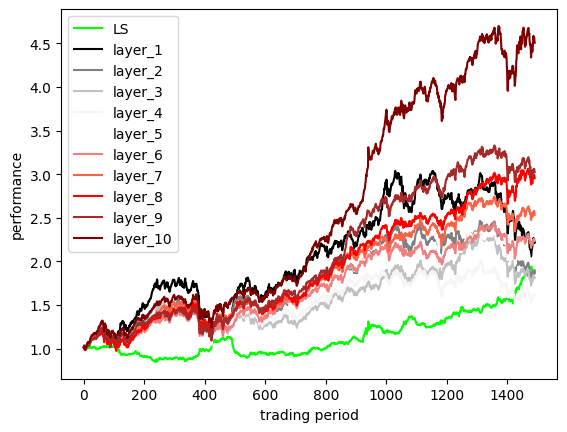

In [310]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[10]-df_T[1]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [311]:
k = pd.Series(k10)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.23536983137449285
annual return 0.2861560167801851
Sharpe ratio 1.5984042845302657


conclusion:change the portfolio monthly is significantly better than change the portfolio quarterly, and long layer 10 seems the best

and we are going to add feature_3 layer label to the stock return according to changing portifolio monthly

In [319]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

In [ ]:
stock_rtn_with_feature_3_layer = layer_by_day(stock_rtn)

In [ ]:
stock_rtn_with_feature_3_layer.to_csv("stock_rtn_with_feature_3_month.csv")

In [323]:
stock_rtn_with_feature_3_layer

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,data_date,security_id,close_price,volume,group_id,in_trading_universe,ret1d,log_ret_1,year,month,quarter,matching_month,d3,layer
0,0,88662,88662,88662,20100201,93201,33.440,90457.0,15103010,N,-0.042108,-0.000299,2010,201002,2010q1,201002,154.669847,9
1,1,88667,88667,88667,20100201,131901,21.640,7891942.0,15104050,Y,0.063914,0.011486,2010,201002,2010q1,201002,-30.124976,2
2,2,88670,88670,88670,20100201,137201,1.300,18000.0,20104010,N,-0.015151,-0.015426,2010,201002,2010q1,201002,146.038376,9
3,3,88672,88672,88672,20100201,140501,1.980,41203.0,45203015,N,-0.010000,0.020001,2010,201002,2010q1,201002,64.522799,5
4,4,88675,88675,88675,20100201,147701,25.380,36774300.0,50101020,Y,0.000788,0.012141,2010,201002,2010q1,201002,76.222480,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987957,1987957,8618848,8617904,4306229,20171031,1115924801,34.050,338353.0,20107010,Y,0.015206,-0.009442,2017,201710,2017q4,201710,50.668755,7
1987958,1987958,8618879,8617935,4306260,20171031,1116120701,20.500,175141.0,25504060,N,0.004902,0.013566,2017,201710,2017q4,201710,-65.408053,2
1987959,1987959,8618906,8617962,4306287,20171031,1116292901,34.750,214123.0,45101010,Y,0.014303,0.013718,2017,201710,2017q4,201710,-0.871261,4
1987960,1987960,8618942,8617998,4306323,20171031,1116510501,3.625,8646.0,40203010,N,0.006944,0.020479,2017,201710,2017q4,201710,-607.543794,1


now try to add feature_9 to monthly portfolio

In [324]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_month.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [325]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        trade_list.append(list(set(q1["security_id"])))
        factor_df_layers = Rank_qcut(q1["d9"], 7)
        q1["layer"] = factor_df_layers
        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

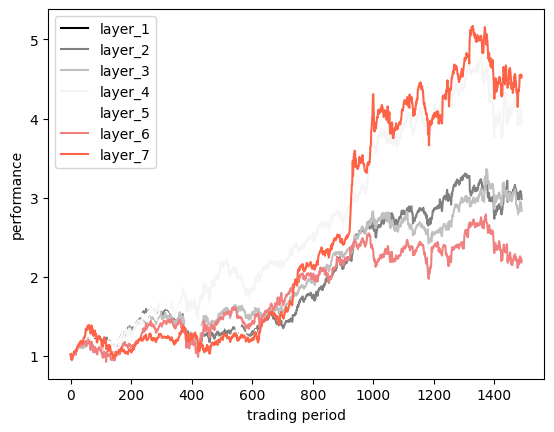

max drawdown： -0.2968367150909309
annual return 0.285396867790245
Sharpe ratio 1.1557869747896745


In [326]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T.index = range(len(df_T))
# df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
# k8 = cal_rtn(df_T[8])
# k9 = cal_rtn(df_T[9])
# k10 = cal_rtn(df_T[10])
# k11 = cal_rtn(df_T["LS"])
# plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
# plt.plot(x,k8,color = 'red',label="layer_8")
# plt.plot(x,k9,color = 'brown',label="layer_9")
# plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k7)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

now try to add feature_9 to quarterly portfolio

In [327]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [328]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 20) #classify as 20 layers 

        q1["layer"] = factor_df_layers
        trade_list.append(list(set(q1["security_id"])))

        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
        
        
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

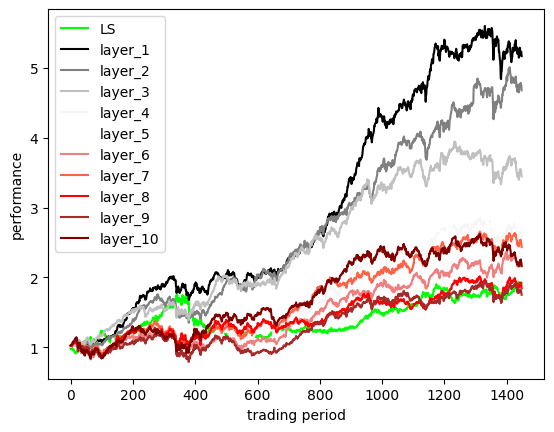

max drawdown： -0.16886938329704015
annual return 0.3291143825657479
Sharpe ratio 2.2744645278242754


In [330]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

# it seems that the quarterly changed portfolio based on feature 3 with daily turnover based on feature 9 has the best performance,so we choose it as our final strategy

# out sample test:

In [332]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

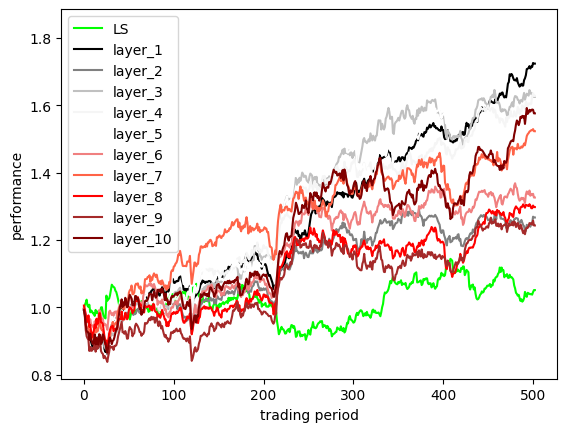

max drawdown： -0.1245660488285053
annual return 0.3198939532404299
Sharpe ratio 2.491866388113577


In [333]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year >= 2016)]
df = classificaiton_rtn(stock_rtn_layer_10)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

next we will find out whether a stock is in the trading universe or not

find out the if the stock can be both in and out the trading universe

In [ ]:
koi = []
for idx in list(set(stock_rtn.security_id)):
    koi.append(len(stock_rtn[(stock_rtn.security_id == idx)&(stock_rtn.in_trading_universe == "Y")])*len(stock_rtn[(stock_rtn.security_id == idx)&(stock_rtn.in_trading_universe == "N")]))

print(set(koi))

so we find that once a stock is not in a trading universe it will never be in the universe

In [385]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

In [386]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")
stock_rtn = stock_rtn.dropna()

begin with quarterly change the portfolio without considering change the daily changing of portfolio based on feature_9

In [387]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

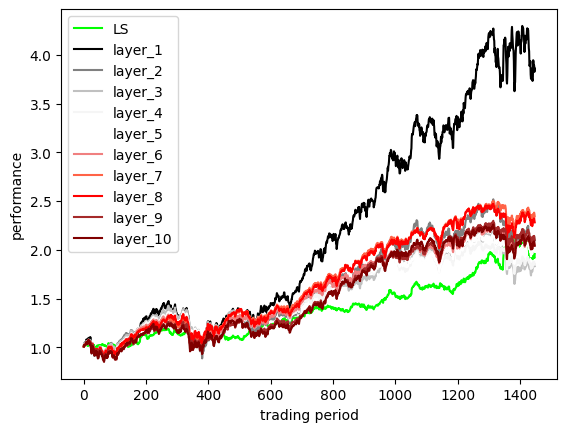

In [336]:
stock_rtn_training = stock_rtn[stock_rtn.year <= 2015]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [337]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.3670857494792079
annual return 0.2619202722671119
Sharpe ratio 1.043622053419279


monthly change the portfolio

In [346]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_month"]]
feature_3["matching_month"] = feature_3["next_month"]
feature_3["matching_month"] = feature_3["matching_month"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_month",axis =1)

In [347]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_month"] = stock_rtn["month"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_month"],how = "left")
stock_rtn = stock_rtn.dropna()

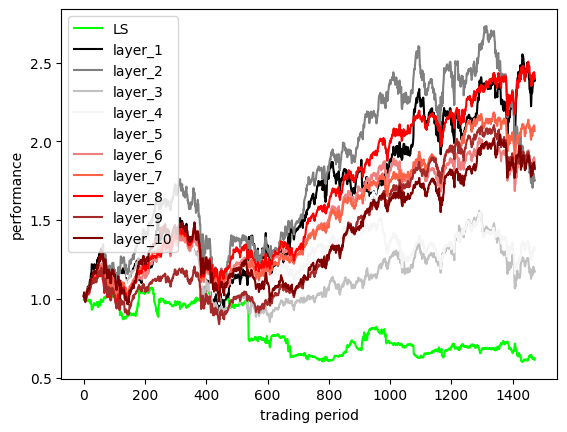

In [348]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015" ]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[10]-df_T[1]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [345]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.4152311783556123
annual return 0.1565128264039104
Sharpe ratio 0.5518690044951696


In [ ]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

now add feature_9

In [351]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_month.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [357]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 7)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        trade_list.append(list(set(q1["security_id"])))


        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

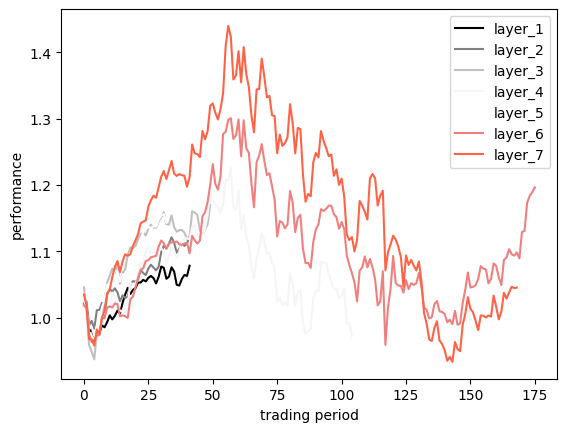

max drawdown： -0.3515493586150088
annual return nan
Sharpe ratio nan


In [358]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T.index = range(len(df_T))
# df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
# k8 = cal_rtn(df_T[8])
# k9 = cal_rtn(df_T[9])
# k10 = cal_rtn(df_T[10])
# k11 = cal_rtn(df_T["LS"])
# plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
# plt.plot(x,k8,color = 'red',label="layer_8")
# plt.plot(x,k9,color = 'brown',label="layer_9")
# plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k7)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

now try to add feature_9 to quarterly portfolio

In [381]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 2]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [382]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 10) #classify as 20 layers 
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]

        trade_list.append(list(set(q1["security_id"])))

        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
        
        
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

In [383]:
df

,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,...,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d
layer,,,,,,,,,,,,,,,,,,,,,
2,0.009355,0.003024,0.029381,-0.008583,0.006703,-0.001657,-0.018789,0.021224,-0.000748,-0.034425,...,0.004813,0.004612,0.001778,0.007442,0.004046,-0.005367,0.014056,-0.005987,-0.006132,-0.016331
3,0.020615,-0.001155,-0.010939,0.017872,0.001425,0.013753,-0.000764,0.015664,-0.002348,-0.004362,...,-0.012905,0.002517,0.009607,0.022924,-0.004872,-0.010284,0.009587,-0.017962,0.006821,-0.011876
4,0.002714,0.007092,0.014504,-0.008093,0.000506,-0.005618,-0.003592,0.008741,0.005099,-0.011669,...,-0.016464,-0.014703,0.018317,0.044573,-0.009277,-0.022855,0.017500,-0.008016,0.006356,-0.012741
5,0.029266,0.015663,0.009219,0.014336,0.005860,-0.003291,-0.002508,0.008564,0.004948,-0.018985,...,-0.006829,0.019071,0.005355,0.046270,0.005512,-0.027896,0.015052,-0.020343,0.012864,-0.006362
6,0.011613,-0.006691,-0.006531,0.010398,-0.002117,0.003796,0.005170,0.020410,0.003218,-0.000897,...,0.005573,-0.024541,0.012033,0.074252,-0.005940,-0.056983,0.017186,-0.020101,0.019706,0.004449
7,0.015259,-0.002062,-0.004704,-0.002598,0.009087,0.011067,0.000018,0.041448,0.010778,-0.018073,...,-0.006934,-0.005355,0.008163,0.074592,-0.009511,-0.034569,0.019438,-0.030412,0.013576,-0.000398
8,0.035199,0.027945,-0.016679,0.014217,0.004989,0.021589,-0.009359,0.021310,0.004313,-0.005004,...,-0.016609,-0.026892,0.016795,0.055847,0.001426,-0.009856,0.013137,-0.021101,0.002577,0.011714
9,0.008532,0.006502,-0.009368,0.011827,-0.000916,0.006785,-0.007651,0.028594,0.006055,-0.019665,...,-0.012423,0.020061,NaN,NaN,0.001179,-0.002367,-0.005296,-0.009531,0.003025,0.024745
10,-0.006777,-0.001814,0.005588,-0.004273,NaN,NaN,NaN,NaN,0.028340,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


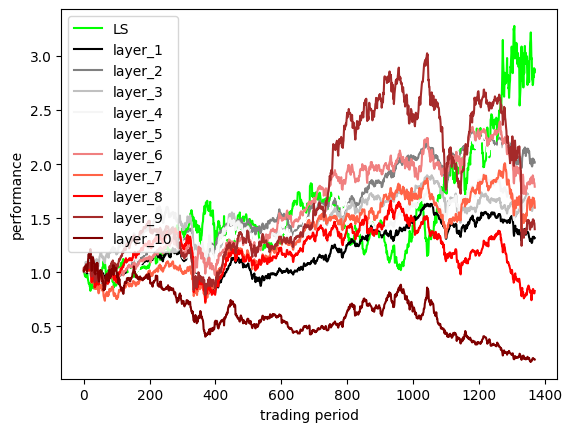

max drawdown： -0.3915657121382232
annual return 0.04797164029335477
Sharpe ratio 0.21844520802700407


In [384]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

# it seems that the quarterly changed portfolio based on feature 3 has the best performance,so we choose it as our final strategy

# out sample test:

In [388]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")
stock_rtn = stock_rtn.dropna()

In [389]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

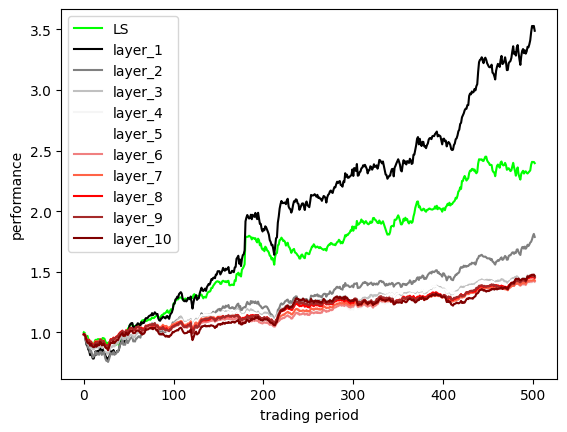

max drawdown： -0.21180219120629173
annual return 0.882953166548879
Sharpe ratio 3.2385938392199978


In [393]:
stock_rtn_training = stock_rtn[stock_rtn.year >= "2016"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))